In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Tetgen multi-domain meshing from data volume

This notebook demonstrates an example using [tetgen](https://wias-berlin.de/software/tetgen/) as the tetrahedralizer starting from a data volume.

Tetgen file formats:
http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual006.html#ff_poly

In [2]:
from itertools import islice
from collections import namedtuple
import numpy as np
from nanomesh import Volume

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<IPython.core.display.Javascript object>


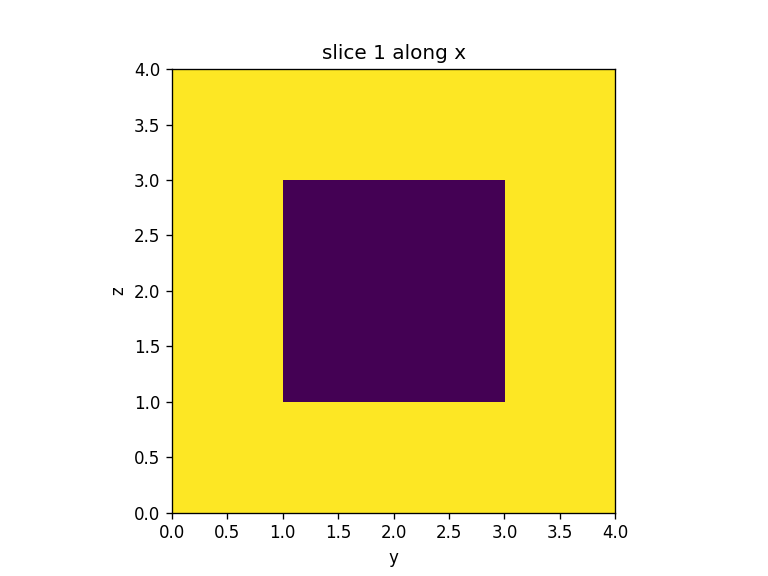

interactive(children=(IntSlider(value=1, description='index', max=3), RadioButtons(description='along', option…

In [3]:
data = np.ones([4, 4, 4], dtype=int)
data[1:3, 1:3, 0:4] = 0

vol = Volume(data)
vol.show_slice()

<IPython.core.display.Javascript object>


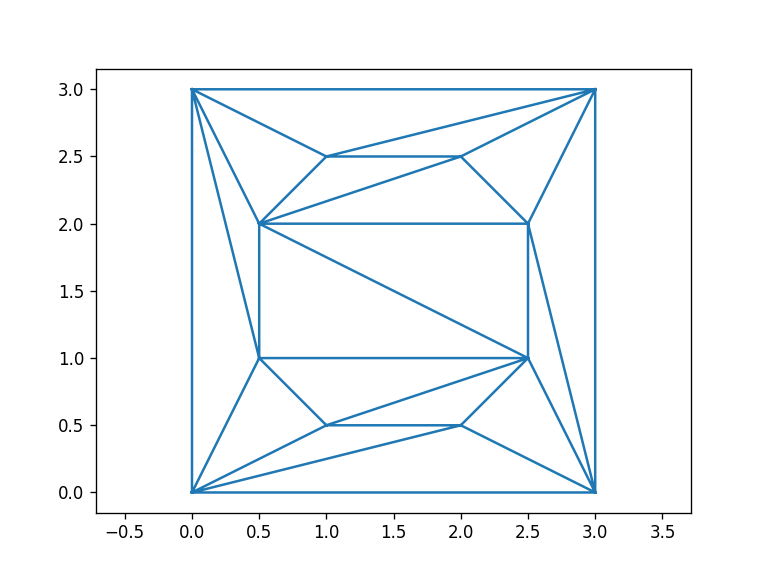

<IPython.core.display.Javascript object>


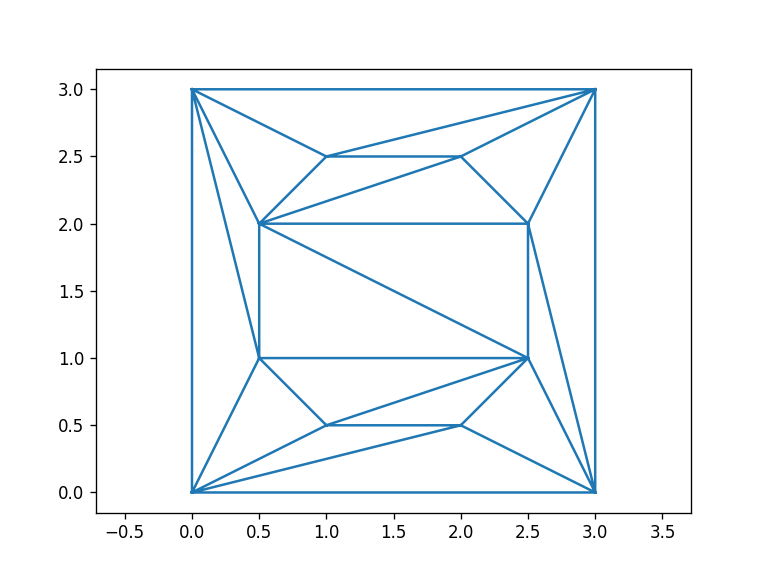

<IPython.core.display.Javascript object>


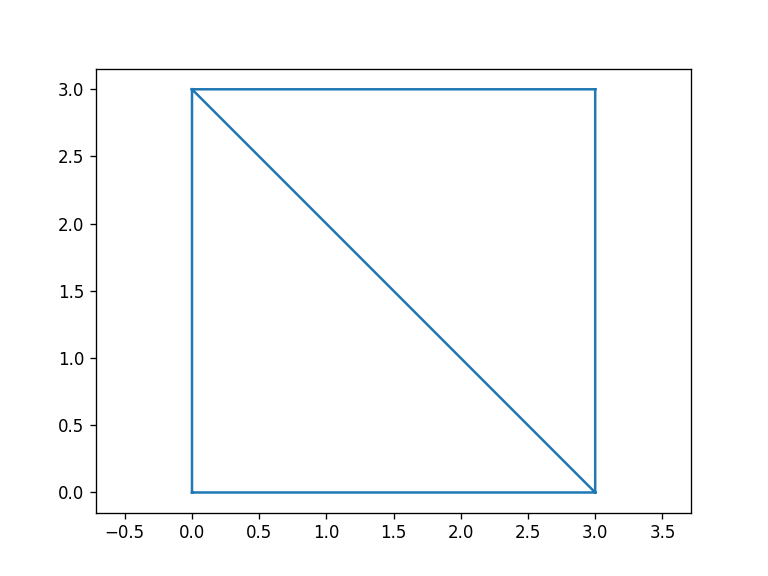

<IPython.core.display.Javascript object>


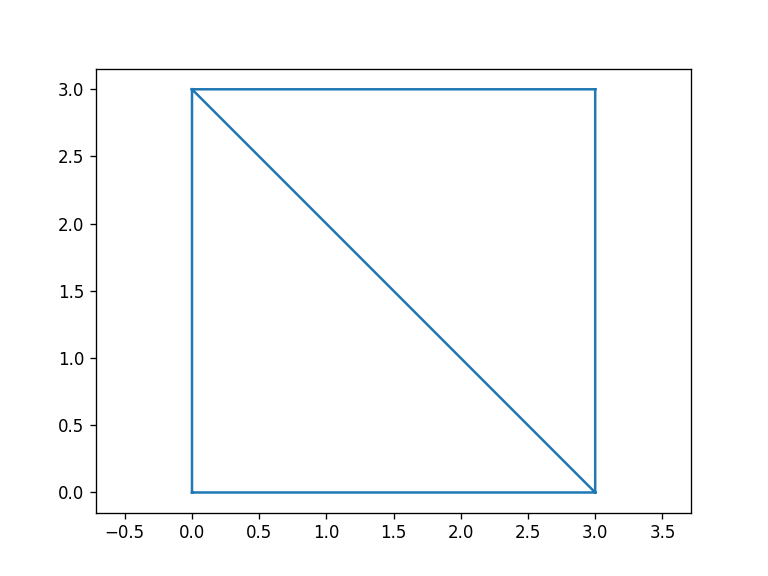

<IPython.core.display.Javascript object>


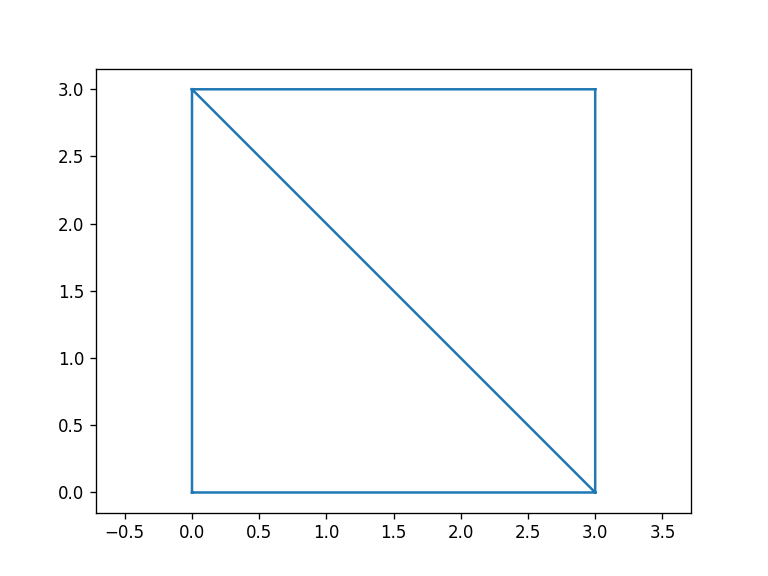

<IPython.core.display.Javascript object>


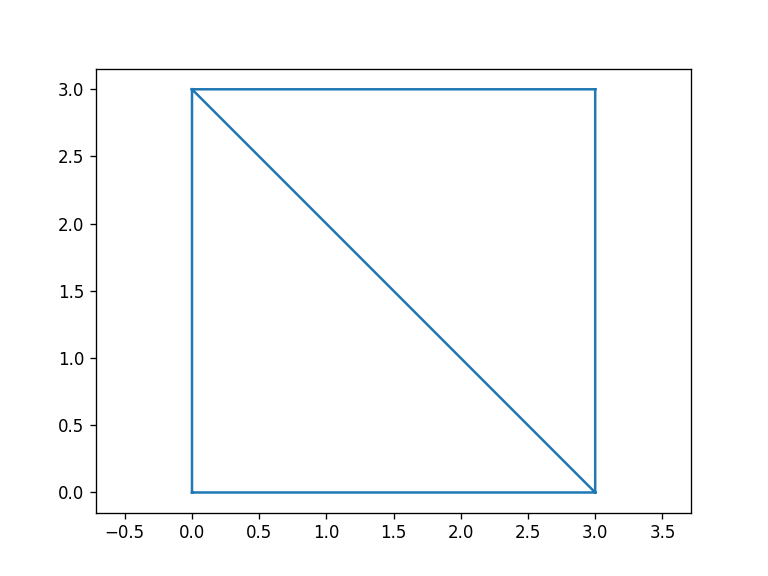

Generated contour with 92  faces (label=1)


In [4]:
from nanomesh.mesh3d import Mesher3D

mesher = Mesher3D(vol)
mesher.generate_contour()

In [5]:
mesher.contours[1].plot_itk()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [6]:
tetras = mesher.tetrahedralize()
tetras.metadata['labels2'] = tetras.metadata.pop('tetgen.ref')
tetras.plot_itk()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…